<a href="https://colab.research.google.com/github/pymoux/wildfires_DST/blob/Michael/Wildfires_data_forest_240524.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<font color='red'>Import libraries</font>**

In [1]:
# Import librairies
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import plotly.express as px
from sklearn.linear_model import LinearRegression

%matplotlib inline

#**<font color='green'>Mount GoogleDrive</font>**

In [2]:
# Mount GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**<font color='purple'>Datasets</font>**

Various datasets will be compiled to conduct our analysis from the US Forest Service point of view

##**Creation of a calendar dataframe**

In [ ]:
# Calendar dataframe for the whole study period
calendar_df = pd.DataFrame({'date':pd.date_range(start='1/1/1992', end='12/31/2015')})
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['weekday'] = calendar_df['date'].dt.weekday #Monday=0

calendar_df.head(10)

In [ ]:
calendar_df.info()

##**Load weather data**

In [ ]:
# Climate data
climate = "/content/drive/MyDrive/Data_Scientest/weather_data_forest.csv.gz"
cdf = pd.read_csv(climate, compression = 'gzip', index_col = 0)
## Convert 'date' column in datetime64[ns]
cdf['date'] = pd.to_datetime(cdf['date'])
pd.set_option('display.max_columns', None)

cdf.head(10)

In [ ]:
cdf.info()

##**Load lightnings data**

In [ ]:
# Lightning data
lightning = "/content/drive/MyDrive/Data_Scientest/light_data_forest.csv.gz"
ldf = pd.read_csv(lightning, compression = 'gzip')
# Convert '#ZDAY' column in datetime64[ns]
ldf['#ZDAY'] = pd.to_datetime(ldf['#ZDAY'], format='%Y-%m-%d')
ldf = ldf.rename(columns={'#ZDAY':'date', 'TOTAL_COUNT':'#lightnings'})
ldf['lightnings'] = 1
pd.set_option('display.max_columns', None)

ldf.head(10)

In [ ]:
ldf.info()

##**Load wildfires data**

In [ ]:
# Load wildfires data
wildfire = "/content/drive/MyDrive/Data_Scientest/wildfires_data_forest.csv.gz"
wdf = pd.read_csv(wildfire, compression = 'gzip')
wdf = wdf.groupby(by=['PROCLAIMED', 'DISCO_DATE']) \
                                .agg({'FOD_ID':'count'}).rename(columns={'FOD_ID':'#wildfires'}).reset_index()
wdf['DISCO_DATE'] = pd.to_datetime(wdf['DISCO_DATE'], format='%Y-%m-%d')
wdf = wdf.rename(columns={'DISCO_DATE':'date'})
pd.set_option('display.max_columns', None)

wdf.head(10)

In [ ]:
wdf.info()

##**Load forests data**

In [ ]:
# Load forests with states
forest = "/content/drive/MyDrive/Data_Scientest/us_forests_ext_d100+state.csv.gz"
fdf = pd.read_csv(forest, compression = 'gzip', index_col = 0)
pd.set_option('display.max_columns', None)

fdf.head(10)

In [ ]:
fdf.info()

#**<font color='darkblue'>Merging datasets</font>**

In [ ]:
# Merge calendar with weather data
global_df = pd.merge(calendar_df, cdf, on='date', how='left')

# Add lightnings data
global_df = pd.merge(global_df, ldf, on=['date', 'PROCLAIMED'], how='left')

# Add wildfires data
global_df = pd.merge(global_df, wdf, on=['date', 'PROCLAIMED'], how='left')

# Add forests data
global_df = pd.merge(global_df, fdf, on='PROCLAIMED', how='left')

global_df.head(10)

In [ ]:
global_df.info()

#**<font color='lightblue'>Visualization</font>**

In [16]:
# Calculate the total number of wildfires for each forest
forest_fire_count = global_df.groupby('FORESTNAME')['#wildfires'].sum()

# Sort forests based on total number of wildfires and select top 10
top_10_most_affected_forests = forest_fire_count.nlargest(10)

# Display the top 10 forests most impacted by fires
print("Top 10 forests most impacted by fires:")
print(top_10_most_affected_forests)

Top 10 forests most impacted by fires:
FORESTNAME
Coconino National Forest          9105.0
Tonto National Forest             6042.0
Deschutes National Forest         5443.0
Ouachita National Forest          4948.0
Chattahoochee National Forest     4250.0
Mark Twain National Forest        4134.0
Nantahala National Forest         4109.0
Lolo National Forest              4028.0
San Bernardino National Forest    3958.0
Gila National Forest              3926.0
Name: #wildfires, dtype: float64


In [17]:
# Count the number of days of fire outbreak for each forest
forest_fire_days_count = global_df.groupby('FORESTNAME')['#wildfires'].count()

# Sort forests based on total number of fire start days and select the first 10
top_10_most_affected_forests = forest_fire_days_count.nlargest(10)

# Display the top 10 forests most impacted by fires in terms of fire start days
print("Top 10 forests most impacted by fires (in terms of fire start days):")
print(top_10_most_affected_forests)


Top 10 forests most impacted by fires (in terms of fire start days):
FORESTNAME
Coconino National Forest          3235
Tonto National Forest             2806
San Bernardino National Forest    2475
Deschutes National Forest         2435
Ouachita National Forest          2393
Angeles National Forest           2126
Chattahoochee National Forest     2043
Nantahala National Forest         1927
De Soto National Forest           1890
Black Hills National Forest       1859
Kaibab National Forest            1806
Santa Fe National Forest          1709
Eldorado National Forest          1658
Cleveland National Forest         1656
Mark Twain National Forest        1647
Sitgreaves National Forest        1633
Coronado National Forest          1630
Lolo National Forest              1622
Gila National Forest              1611
Toiyabe National Forest           1599
Name: #wildfires, dtype: int64


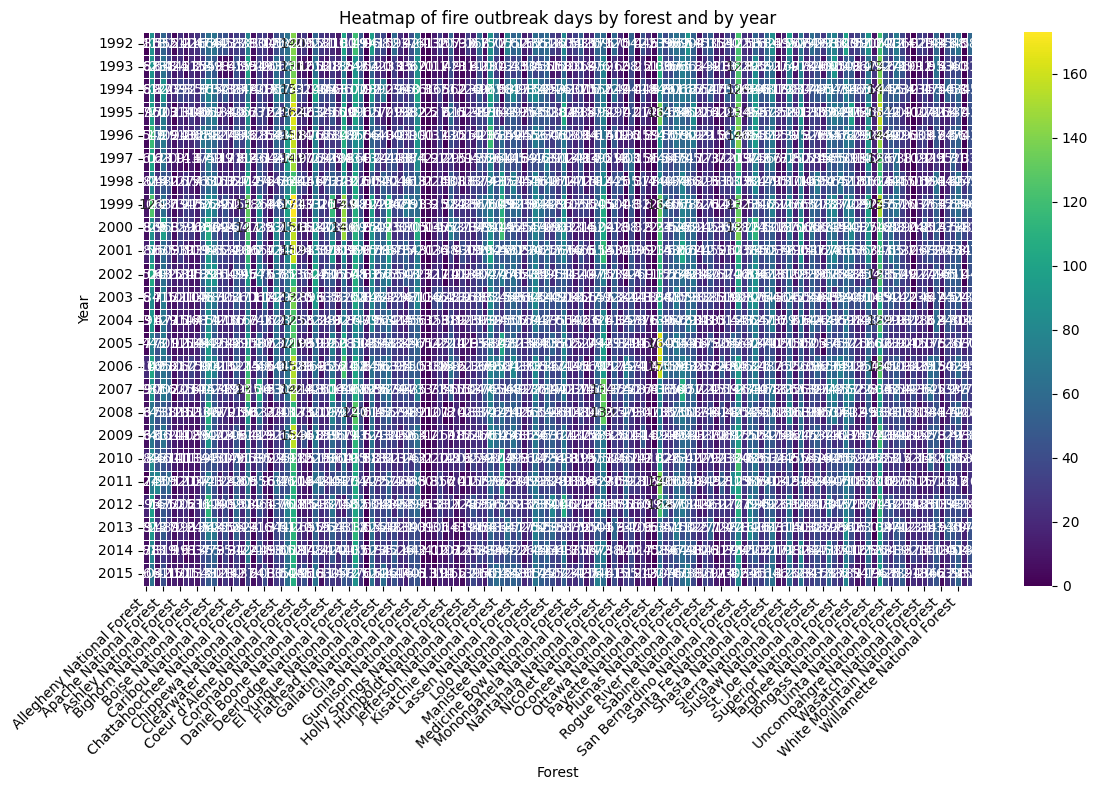

In [20]:
# Heatmap of fire outbreak days by forests and by year



# Group the data by year and by forest, then count the total number of days of fire outbreak
heatmap_data = global_df.groupby([global_df['date'].dt.year, 'FORESTNAME'])['#wildfires'].count().unstack(fill_value=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='d', linewidths=.5)
plt.title("Heatmap of fire outbreak days by forest and by year")
plt.xlabel("Forest")
plt.ylabel("Year")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Evolution of wildfires over the years (ex. Coconino National Forest)

coconino_df = global_df[global_df['FORESTNAME'] == 'Coconino National Forest']
yearly_fire_counts_coconino = coconino_df.groupby('year')['#wildfires'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_fire_counts_coconino['year'], yearly_fire_counts_coconino['#wildfires'], marker='o')
plt.title('Evolution of Wildfires in Coconino National Forest over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Wildfires')
plt.grid(True)
plt.show()

In [ ]:
# Evolution of wildfires over the years (ex. Tonto National Forest)
tonto_df = global_df[global_df['FORESTNAME'] == 'Tonto National Forest']

yearly_fire_counts_tonto = tonto_df.groupby('year')['#wildfires'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_fire_counts_tonto['year'], yearly_fire_counts_tonto['#wildfires'], marker='o')
plt.title('Evolution of Wildfires in Tonto National Forest over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Wildfires')
plt.grid(True)
plt.show()

In [ ]:
# Wildfires trends per forest

global_df['year'] = pd.to_datetime(global_df['date']).dt.year
yearly_fires_by_forest = global_df.groupby(['FORESTNAME', 'year'])['#wildfires'].sum().reset_index()
forests = yearly_fires_by_forest['FORESTNAME'].unique()
forests_with_increasing_fires = []

# Analyze each forest individually
for forest in forests:
    forest_data = yearly_fires_by_forest[yearly_fires_by_forest['FORESTNAME'] == forest]
     if len(forest_data) < 2:
        continue
    X = forest_data['year'].values.reshape(-1, 1)
    y = forest_data['#wildfires'].values

    model = LinearRegression()
    model.fit(X, y)

    slope = model.coef_[0]

    if slope > 0:
        forests_with_increasing_fires.append((forest, slope))

# Display forest with the highest slopes
forests_with_increasing_fires.sort(key=lambda x: x[1], reverse=True)
print("Forests with an increasing number of wildfires over time:")
for forest, slope in forests_with_increasing_fires:
    print(f"{forest}: slope = {slope:.2f}")

# Optionally, visualize the trends for the top few forests with the highest slopes
top_forests = forests_with_increasing_fires[:5]
for forest, slope in top_forests:
    forest_data = yearly_fires_by_forest[yearly_fires_by_forest['FORESTNAME'] == forest]
    X = forest_data['year'].values
    y = forest_data['#wildfires'].values

    plt.figure(figsize=(10, 6))
    plt.plot(X, y, marker='o')
    plt.plot(X, model.predict(X.reshape(-1, 1)), linestyle='--', color='red')
    plt.title(f'Trend of Wildfires in {forest} (slope = {slope:.2f})')
    plt.xlabel('Year')
    plt.ylabel('Number of Wildfires')
    plt.grid(True)
    plt.show()

In [ ]:
# Choropleth wildfires forest
import pandas as pd
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip

# Count the number of days of fire outbreak for each forest
forest_fire_days_count = global_df.groupby('FORESTNAME')['#wildfires'].count()

# Display the forests most impacted by fires in terms of fire start days
print("Forests most impacted by fires (in terms of fire start days):")
print(forest_fire_days_count)

# Load the GeoDataFrame containing the boundaries of national forests
# Replace 'path_to_your_shapefile' with the actual path to your shapefile
forests_gdf = gpd.read_file(r"C:\Users\m.drexler\Documents\DataScientest\Project\Final ML\forests_shape-20240528T075301Z-001\forests_shape\S_USA.ProclaimedForest.shp")

# Ensure the forest names are matched correctly
forests_gdf['FORESTNAME'] = forests_gdf['FORESTNAME'].str.strip()

# Merge the forest fire data with the GeoDataFrame
forests_gdf = forests_gdf.merge(forest_fire_days_count, on='FORESTNAME', how='left')

# Fill NaN values with 0 (for forests that do not have fire start days in the dataset)
forests_gdf['#wildfires'] = forests_gdf['#wildfires'].fillna(0)

# Create a folium map centered on the US
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Add the forest fire data as a choropleth layer
choropleth = folium.Choropleth(
    geo_data=forests_gdf,
    name='choropleth',
    data=forests_gdf,
    columns=['FORESTNAME', '#wildfires'],
    key_on='feature.properties.FORESTNAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Fire Start Days'
).add_to(m)

# Add tooltips to display forest names and fire start days
tooltip = GeoJsonTooltip(
    fields=['FORESTNAME', '#wildfires'],
    aliases=['Forest Name:', 'Number of Fire Start Days:']
)

choropleth.geojson.add_child(tooltip)

# Save the map to an HTML file
m.save('forest_fire_choropleth_all_forests.html')

print("Map has been saved to 'forest_fire_choropleth_all_forests.html'")

In [ ]:
# Choropleth wildfires forests trends over years
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.linear_model import LinearRegression
import folium
from folium.features import GeoJson, GeoJsonTooltip

# Load the shapefile of the forests
forests_gdf = gpd.read_file(r"C:\Users\m.drexler\Documents\DataScientest\Project\Final ML\forests_shape-20240528T075301Z-001\forests_shape\S_USA.ProclaimedForest.shp")

# Add a 'year' column to global_df
global_df['year'] = pd.to_datetime(global_df['date']).dt.year

# Group by forest and year to get the count of wildfires each year
yearly_fires_by_forest = global_df.groupby(['FORESTNAME', 'year'])['#wildfires'].sum().reset_index()

# Get the unique list of forests
forests = yearly_fires_by_forest['FORESTNAME'].unique()

# Dictionary to store the slopes
forest_slopes = {}

# Calculate the slope of wildfires over the years for each forest
for forest in forests:
    forest_data = yearly_fires_by_forest[yearly_fires_by_forest['FORESTNAME'] == forest]

    if len(forest_data) < 2:
        continue

    X = forest_data['year'].values.reshape(-1, 1)
    y = forest_data['#wildfires'].values

    model = LinearRegression()
    model.fit(X, y)

    slope = model.coef_[0]
    forest_slopes[forest] = slope

# Convert the dictionary to a DataFrame
slopes_df = pd.DataFrame(list(forest_slopes.items()), columns=['FORESTNAME', 'slope'])

# Merge with the GeoDataFrame
forests_gdf = forests_gdf.merge(slopes_df, left_on='FORESTNAME', right_on='FORESTNAME', how='left')

# Initialize a Folium map
m = folium.Map(location=[37.8, -96], zoom_start=5)

# Define a color scale
color_scale = folium.LinearColormap(['yellow', 'red'], vmin=slopes_df['slope'].min(), vmax=slopes_df['slope'].max())

# Function to style each feature
def style_function(feature):
    slope = feature['properties']['slope']
    return {
        'fillOpacity': 0.5,
        'weight': 0.5,
        'fillColor': 'gray' if slope is None else color_scale(slope)
    }

# Function to create tooltip
def tooltip_function(feature):
    return folium.Tooltip(f"{feature['properties']['FORESTNAME']}: {feature['properties']['slope']}")

# Add the GeoJson to the map
geojson = GeoJson(
    forests_gdf,
    style_function=style_function,
    tooltip=GeoJsonTooltip(fields=['FORESTNAME', 'slope'])
).add_to(m)

# Add color scale to the map
color_scale.add_to(m)

# Save the map to an HTML file
m.save('forests_fire_trend.html')

#**<font color='grey'>Investigate on top forest (in terms of number of days of fire outbreak and states)</font>**

In [21]:
# Filter data for the forest
## Top 5
coconino_df = global_df[global_df['FORESTNAME'] == 'Coconino National Forest']
tonto_df = global_df[global_df['FORESTNAME'] == 'Tonto National Forest']
sanbernadino_df = global_df[global_df['FORESTNAME'] == 'San Bernardino National Forest']
deschutes_df = global_df[global_df['FORESTNAME'] == 'Deschutes National Forest']
ouachita_df = global_df[global_df['FORESTNAME'] == 'Ouachita National Forest']

## Include other states forest
chattahoochee_df = global_df[global_df['FORESTNAME'] == 'Chattahoochee National Forest']
lolo_df = global_df[global_df['FORESTNAME'] == 'Lolo National Forest']
desoto_df = global_df[global_df['FORESTNAME'] == 'De Soto National Forest']

In [22]:
# List of forests to process
forests = ['Coconino National Forest', 'Tonto National Forest', 'San Bernardino National Forest',
           'Deschutes National Forest', 'Ouachita National Forest', 'Chattahoochee National Forest',
           'Lolo National Forest', 'De Soto National Forest']

#**<font color='darkorange'>Preprocessing</font>**

In [23]:
# Function to prepare the data
def prepare_data(df):
    # Fill missing values for 'lightnings' and '#wildfires' columns
    df = df.fillna({'lightnings': 0, '#wildfires': 0})

    # Select specific columns
    columns_to_keep = [
        'date', 'year', 'month', 'weekday',
        'TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D',
        'TMIN_mean_10D', 'TMIN_mean_30D', 'PRCP_mean',
        'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires'
    ]
    df = df[columns_to_keep]

    # Create derived columns for cumulative wildfires over different time periods
    df['#wildfires_1D'] = df['#wildfires'].rolling(window=1, closed='left').sum()
    df['#wildfires_10D'] = df['#wildfires'].rolling(window=10, closed='left').sum()
    df['#wildfires_30D'] = df['#wildfires'].rolling(window=30, closed='left').sum()

    # Fill missing values for new derived columns
    df = df.fillna({'#wildfires_1D': 0, '#wildfires_10D': 0, '#wildfires_30D': 0})

    # Create a binary target column
    df['target'] = df['#wildfires'].apply(lambda x: 0 if x == 0 else 1)

    return df

#**<font color='blue'>Machine learning</font>**


##***Random Forest Classifier***

In [24]:
# Random Forest Classifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Function to process the data and train the model
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']
     # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a model with the year included
    model_with_year = RandomForestClassifier(n_estimators=200, max_features=4, max_depth=None, random_state=42)
    model_with_year.fit(X_train, y_train)
    y_pred_with_year = model_with_year.predict(X_test)
    accuracy_with_year = accuracy_score(y_test, y_pred_with_year)

    # Evaluate the model performance
    print("Accuracy with year:", accuracy_with_year)
    print(classification_report(y_test, y_pred_with_year))

    # Remove the year column from the dataset
    X_no_year = X.drop(columns=['year'])
    X_train_no_year, X_test_no_year, y_train_no_year, y_test_no_year = train_test_split(X_no_year, y, test_size=0.2, random_state=42)

    # Train a model without the year
    model_without_year = RandomForestClassifier(n_estimators=200, max_features=4, max_depth=None, random_state=42)
    model_without_year.fit(X_train_no_year, y_train_no_year)
    y_pred_without_year = model_without_year.predict(X_test_no_year)
    accuracy_without_year = accuracy_score(y_test_no_year, y_pred_without_year)

    # Evaluate the model performance
    print("Accuracy without year:", accuracy_without_year)
    print(classification_report(y_test_no_year, y_pred_without_year))

In [25]:
# Process each forest
for forest in forests:
    print(f"\nProcessing {forest}...\n")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)


Processing Coconino National Forest...

Accuracy with year: 0.7850627137970353
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1107
           1       0.74      0.64      0.69       647

    accuracy                           0.79      1754
   macro avg       0.77      0.76      0.76      1754
weighted avg       0.78      0.79      0.78      1754

Accuracy without year: 0.7810718358038768
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1107
           1       0.73      0.64      0.68       647

    accuracy                           0.78      1754
   macro avg       0.77      0.75      0.76      1754
weighted avg       0.78      0.78      0.78      1754


Processing Tonto National Forest...

Accuracy with year: 0.7633979475484607
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1215
           1       0.64      0.51     

##***Logistic Regression***

In [26]:
# Logistic Regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Logistic Regression model with the year included
    model_with_year = LogisticRegression(penalty='l2', C=1.0)
    model_with_year.fit(X_train, y_train)
    y_pred_with_year = model_with_year.predict(X_test)
    accuracy_with_year = accuracy_score(y_test, y_pred_with_year)

    # Print the accuracy and classification report for the model with year
    print("\nLogistic Regression with year:")
    print("Accuracy:", accuracy_with_year)
    print(classification_report(y_test, y_pred_with_year))

    # Remove the year column from the dataset
    X_no_year = X.drop(columns=['year'])
    X_train_no_year, X_test_no_year, y_train_no_year, y_test_no_year = train_test_split(X_no_year, y, test_size=0.2, random_state=42)

    # Train a Logistic Regression model without the year
    model_without_year = LogisticRegression(penalty='l2', C=1.0)
    model_without_year.fit(X_train_no_year, y_train_no_year)
    y_pred_without_year = model_without_year.predict(X_test_no_year)
    accuracy_without_year = accuracy_score(y_test_no_year, y_pred_without_year)

    # Print the accuracy and classification report for the model without year
    print("\nLogistic Regression without year:")
    print("Accuracy:", accuracy_without_year)
    print(classification_report(y_test, y_pred_without_year))

In [27]:
# Process each forest
for forest in forests:
    print(f"Processing forest: {forest}")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

Processing forest: Coconino National Forest

Logistic Regression with year:
Accuracy: 0.7770809578107184
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1107
           1       0.74      0.60      0.67       647

    accuracy                           0.78      1754
   macro avg       0.77      0.74      0.75      1754
weighted avg       0.77      0.78      0.77      1754


Logistic Regression without year:
Accuracy: 0.7856328392246295
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1107
           1       0.75      0.63      0.68       647

    accuracy                           0.79      1754
   macro avg       0.78      0.75      0.76      1754
weighted avg       0.78      0.79      0.78      1754

Processing forest: Tonto National Forest

Logistic Regression with year:
Accuracy: 0.7696693272519954
              precision    recall  f1-score   support

           0       0

##***Multi Layer Perceptron***

In [ ]:
# Multi Layer Perceptron
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train an MLPClassifier with the year included
    model_with_year = MLPClassifier(hidden_layer_sizes=(50,), activation='identity', alpha=0.005,
                                    learning_rate='adaptive', solver='sgd', random_state=42, max_iter=1000)
    model_with_year.fit(X_train, y_train)
    y_pred_with_year = model_with_year.predict(X_test)
    accuracy_with_year = accuracy_score(y_test, y_pred_with_year)

    # Print the accuracy and classification report for the model with year
    print("\nMLP Classifier with year:")
    print("Accuracy:", accuracy_with_year)
    print(classification_report(y_test, y_pred_with_year))

    # Remove the year column from the dataset
    X_no_year = X.drop(columns=['year'])
    X_train_no_year, X_test_no_year, y_train_no_year, y_test_no_year = train_test_split(X_no_year, y, test_size=0.2, random_state=42)

    # Train an MLPClassifier without the year
    model_without_year = MLPClassifier(hidden_layer_sizes=(50,), activation='identity', alpha=0.005,
                                       learning_rate='adaptive', solver='sgd', random_state=42, max_iter=1000)
    model_without_year.fit(X_train_no_year, y_train_no_year)
    y_pred_without_year = model_without_year.predict(X_test_no_year)
    accuracy_without_year = accuracy_score(y_test_no_year, y_pred_without_year)

    # Print the accuracy and classification report for the model without year
    print("\nMLP Classifier without year:")
    print("Accuracy:", accuracy_without_year)
    print(classification_report(y_test, y_pred_without_year))

In [ ]:
# Process each forest
for forest in forests:
    print(f"Processing forest: {forest}")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

##***Support Vector Machine***

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train an SVM model with the year included
    model_with_year = SVC(kernel='rbf', gamma=0.0001, C=100)
    model_with_year.fit(X_train, y_train)
    y_pred_with_year = model_with_year.predict(X_test)
    accuracy_with_year = accuracy_score(y_test, y_pred_with_year)

    # Print the accuracy and classification report for the model with year
    print("\nSVM with year:")
    print("Accuracy:", accuracy_with_year)
    print(classification_report(y_test, y_pred_with_year))

    # Remove the year column from the dataset
    X_no_year = X.drop(columns=['year'])
    X_train_no_year, X_test_no_year, y_train_no_year, y_test_no_year = train_test_split(X_no_year, y, test_size=0.2, random_state=42)

    # Train an SVM model without the year
    model_without_year = SVC(kernel='rbf', gamma=0.0001, C=100)
    model_without_year.fit(X_train_no_year, y_train_no_year)
    y_pred_without_year = model_without_year.predict(X_test_no_year)
    accuracy_without_year = accuracy_score(y_test_no_year, y_pred_without_year)

    # Print the accuracy and classification report for the model without year
    print("\nSVM without year:")
    print("Accuracy:", accuracy_without_year)
    print(classification_report(y_test, y_pred_without_year))


In [ ]:
# Process each forest
for forest in forests:
    print(f"Processing forest: {forest}")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train(forest_df)

##***Gradient Boosting Classifier***

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Function to train Gradient Boosting Classifier
def train_gradient_boosting(X_train, y_train, X_test, y_test):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))

# Process each forest
for forest in forests:
    print(f"Processing forest: {forest}")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)

    X = forest_df.drop(['date', 'target', '#wildfires', 'year'], axis=1)  # Drop 'year' here
    y = forest_df['target']

    num_cols = [
        'TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D',
        'TMIN_mean_10D', 'TMIN_mean_30D', 'PRCP_mean',
        'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings',
        '#wildfires_1D', '#wildfires_10D', '#wildfires_30D'
    ]
    circular_cols = ['month', 'weekday']

    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    X = X.drop(columns=circular_cols)

    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("\nGradient Boosting Classifier without 'year':")
    train_gradient_boosting(X_train, y_train, X_test, y_test)


##***Random Forest Classifier + SMOTE***

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Function to process the data and train the model
def process_and_train_smote(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train a model with the year included
    model_with_year = RandomForestClassifier(n_estimators=200, max_features=4, max_depth=None, random_state=42)
    model_with_year.fit(X_train_smote, y_train_smote)
    y_pred_with_year_smote = model_with_year.predict(X_test)
    accuracy_with_year_smote = accuracy_score(y_test, y_pred_with_year_smote)

    # Evaluate the model performance
    print("Accuracy with year:", accuracy_with_year_smote)
    print(classification_report(y_test, y_pred_with_year_smote))

    # Remove the year column from the dataset
    X_no_year = X.drop(columns=['year'])
    X_train_no_year, X_test_no_year, y_train_no_year, y_test_no_year = train_test_split(X_no_year, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data without year
    X_train_no_year_smote, y_train_no_year_smote = smote.fit_resample(X_train_no_year, y_train_no_year)

    # Train a model without the year
    model_without_year = RandomForestClassifier(n_estimators=200, max_features=4, max_depth=None, random_state=42)
    model_without_year.fit(X_train_no_year_smote, y_train_no_year_smote)
    y_pred_without_year_smote = model_without_year.predict(X_test_no_year)
    accuracy_without_year_smote = accuracy_score(y_test_no_year, y_pred_without_year_smote)

    # Evaluate the model performance
    print("Accuracy without year:", accuracy_without_year_smote)
    print(classification_report(y_test_no_year, y_pred_without_year_smote))

In [ ]:
# Process each forest
for forest in forests:
    print(f"Processing forest: {forest}")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train_smote(forest_df)

##***Logistic Regression + SMOTE***

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train a Logistic Regression model with the year included
    model_with_year = LogisticRegression(penalty='l2', C=1.0)
    model_with_year.fit(X_train_smote, y_train_smote)
    y_pred_with_year_smote = model_with_year.predict(X_test)
    accuracy_with_year_smote = accuracy_score(y_test, y_pred_with_year_smote)

    # Print the accuracy and classification report for the model with year
    print("\nLogistic Regression with year:")
    print("Accuracy:", accuracy_with_year_smote)
    print(classification_report(y_test, y_pred_with_year_smote))

    # Remove the year column from the dataset
    X_no_year = X.drop(columns=['year'])
    X_train_no_year, X_test_no_year, y_train_no_year, y_test_no_year = train_test_split(X_no_year, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data without year
    X_train_no_year_smote, y_train_no_year_smote = smote.fit_resample(X_train_no_year, y_train_no_year)

    # Train a Logistic Regression model without the year
    model_without_year = LogisticRegression(penalty='l2', C=1.0)
    model_without_year.fit(X_train_no_year_smote, y_train_no_year_smote)
    y_pred_without_year_smote = model_without_year.predict(X_test_no_year)
    accuracy_without_year_smote = accuracy_score(y_test_no_year, y_pred_without_year_smote)

    # Print the accuracy and classification report for the model without year
    print("\nLogistic Regression without year:")
    print("Accuracy:", accuracy_without_year_smote)
    print(classification_report(y_test, y_pred_without_year_smote))

In [ ]:
# Process each forest
for forest in forests:
    print(f"Processing forest: {forest}")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train_smote(forest_df)

##***Multi Layer Perceptron + SMOTE***

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train an MLPClassifier with the year included
    model_with_year = MLPClassifier(hidden_layer_sizes=(50,), activation='identity', alpha=0.005,
                                    learning_rate='adaptive', solver='sgd', random_state=42, max_iter=1000)
    model_with_year.fit(X_train_smote, y_train_smote)
    y_pred_with_year_smote = model_with_year.predict(X_test)
    accuracy_with_year_smote = accuracy_score(y_test, y_pred_with_year_smote)

    # Print the accuracy and classification report for the model with year
    print("\nMLP Classifier with year:")
    print("Accuracy:", accuracy_with_year)
    print(classification_report(y_test, y_pred_with_year))

    # Remove the year column from the dataset
    X_no_year = X.drop(columns=['year'])
    X_train_no_year, X_test_no_year, y_train_no_year, y_test_no_year = train_test_split(X_no_year, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data without year
    X_train_no_year_smote, y_train_no_year_smote = smote.fit_resample(X_train_no_year, y_train_no_year)

    # Train an MLPClassifier without the year
    model_without_year = MLPClassifier(hidden_layer_sizes=(50,), activation='identity', alpha=0.005,
                                       learning_rate='adaptive', solver='sgd', random_state=42, max_iter=1000)
    model_without_year.fit(X_train_no_year_smote, y_train_no_year_smote)
    y_pred_without_year_smote = model_without_year.predict(X_test_no_year)
    accuracy_without_year_smote = accuracy_score(y_test_no_year, y_pred_without_year_smote)

    # Print the accuracy and classification report for the model without year
    print("\nMLP Classifier without year:")
    print("Accuracy:", accuracy_without_year)
    print(classification_report(y_test, y_pred_without_year))

In [ ]:
# Process each forest
for forest in forests:
    print(f"Processing forest: {forest}")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train_smote(forest_df)

##***Multi Layer Perceptron + SMOTE***

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Function to process the data and train the models
def process_and_train(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train an SVM model with the year included
    model_with_year = SVC(kernel='rbf', gamma=0.0001, C=100)
    model_with_year.fit(X_train_smote, y_train_smote)
    y_pred_with_year_smote = model_with_year.predict(X_test)
    accuracy_with_year_smote = accuracy_score(y_test, y_pred_with_year_smote)

    # Print the accuracy and classification report for the model with year
    print("\nSVM with year:")
    print("Accuracy:", accuracy_with_year_smote)
    print(classification_report(y_test, y_pred_with_year_smote))

    # Remove the year column from the dataset
    X_no_year = X.drop(columns=['year'])
    X_train_no_year, X_test_no_year, y_train_no_year, y_test_no_year = train_test_split(X_no_year, y, test_size=0.2, random_state=42)

    # Apply SMOTE to the training data without year
    X_train_no_year_smote, y_train_no_year_smote = smote.fit_resample(X_train_no_year, y_train_no_year)

    # Train an SVM model without the year
    model_without_year = SVC(kernel='rbf', gamma=0.0001, C=100)
    model_without_year.fit(X_train_no_year_smote, y_train_no_year_smote)
    y_pred_without_year_smote = model_without_year.predict(X_test_no_year)
    accuracy_without_year_smote = accuracy_score(y_test_no_year, y_pred_without_year_smote)

    # Print the accuracy and classification report for the model without year
    print("\nSVM without year:")
    print("Accuracy:", accuracy_without_year)
    print(classification_report(y_test, y_pred_without_year))


In [ ]:
# Process each forest
for forest in forests:
    print(f"Processing forest: {forest}")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train_smote(forest_df)

##***Gradient Boosting Classifier + SMOTE***

In [ ]:
# Function to train Gradient Boosting Classifier
def train_gradient_boosting(X_train, y_train, X_test, y_test):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))

# Process each forest
for forest in forests:
    print(f"Processing forest: {forest}")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)

    X = forest_df.drop(['date', 'target', '#wildfires'], axis=1)
    y = forest_df['target']

    num_cols = [
        'TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D',
        'TMIN_mean_10D', 'TMIN_mean_30D', 'PRCP_mean',
        'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings',
        '#wildfires_1D', '#wildfires_10D', '#wildfires_30D'
    ]
    circular_cols = ['month', 'weekday']

    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    X = X.drop(columns=circular_cols)

    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    print("\nGradient Boosting Classifier with 'year':")
    train_gradient_boosting(X_train_res, y_train_res, X_test, y_test)

##***Random Forest Classifier + Tomek Link***

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

# Function to process the data and train the model
def process_and_train_smote(df):
    # Data preparation
    X = df.drop(['date', 'target', '#wildfires'], axis=1)
    y = df['target']

    # Set numeric and circular columns
    num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D',
                'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires_1D', '#wildfires_10D',
                '#wildfires_30D']
    circular_cols = ['month', 'weekday']

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    # Create sin and cos for circular columns
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Drop original circular columns
    X = X.drop(columns=circular_cols)

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply TOMEK Link
    tomek = TomekLinks()
    X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)

    # Train a model with the year included
    model_with_year = RandomForestClassifier(n_estimators=200, max_features=4, max_depth=None, random_state=42)
    model_with_year.fit(X_train_tomek, y_train_tomek)
    y_pred_with_year_tomek = model_with_year.predict(X_test)
    accuracy_with_year_tomek = accuracy_score(y_test, y_pred_with_year_tomek)

    # Evaluate the model performance
    print("Accuracy with year:", accuracy_with_year_tomek)
    print(classification_report(y_test, y_pred_with_year_tomek))

    # Remove the year column from the dataset
    X_no_year = X.drop(columns=['year'])
    X_train_no_year, X_test_no_year, y_train_no_year, y_test_no_year = train_test_split(X_no_year, y, test_size=0.2, random_state=42)

    # Apply TOMEK Link
    tomek = TomekLinks()
    X_train_no_year_tomek, y_train_no_year_tomek = tomek.fit_resample(X_train_no_year, y_train_no_year)

    # Train a model without the year
    model_without_year = RandomForestClassifier(n_estimators=200, max_features=4, max_depth=None, random_state=42)
    model_without_year.fit(X_train_no_year_tomek, y_train_no_year_tomek)
    y_pred_without_year_tomek = model_without_year.predict(X_test_no_year)
    accuracy_without_year_tomek = accuracy_score(y_test_no_year, y_pred_without_year_tomek)

    # Evaluate the model performance
    print("Accuracy without year:", accuracy_without_year_tomek)
    print(classification_report(y_test_no_year, y_pred_without_year_tomek))

In [ ]:
# Process each forest
for forest in forests:
    print(f"Processing forest: {forest}")
    forest_df = global_df[global_df['FORESTNAME'] == forest]
    forest_df = prepare_data(forest_df)
    process_and_train_smote(forest_df)

#**<font color='darkorange'>Preprocessing (all)</font>**


In [ ]:
# Fill in missing values for 'lightnings' and '#wildfires' columns
global_df = global_df.fillna({'lightnings': 0, '#wildfires': 0})

# Select specific columns
columns_to_keep = [
     'date', 'year', 'month', 'weekday',
     'TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D',
     'TMIN_mean_10D', 'TMIN_mean_30D', 'PRCP_mean',
     'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', '#wildfires'
]
global_df = global_df[columns_to_keep]

# Create derived columns for cumulative wildfires over different time periods
global_df['#wildfires_1D'] = global_df['#wildfires'].rolling(window=1, closed='left').sum()
global_df['#wildfires_10D'] = global_df['#wildfires'].rolling(window=10, closed='left').sum()
global_df['#wildfires_30D'] = global_df['#wildfires'].rolling(window=30, closed='left').sum()

# Fill in missing values for new derived columns
global_df = global_df.fillna({'#wildfires_1D': 0, '#wildfires_10D': 0, '#wildfires_30D': 0})

# Create a binary target column
global_df['target'] = global_df['#wildfires'].apply(lambda x: 0 if x == 0 else 1)

# Show final dataframe
global_df.head(10)

#**<font color='violet'>Train/test datasets (all)</font>**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Data preparation
X = global_df.drop(['date', 'target', '#wildfires'], axis=1)
y = global_df['target']

# Set number and circular columns
num_cols = ['TMAX_mean', 'TMIN_mean', 'TMAX_mean_10D', 'TMAX_mean_30D', 'TMIN_mean_10D', 'TMIN_mean_30D', 'PRCP_mean', 'PRCP_mean_10D', 'PRCP_mean_30D', 'lightnings', s_1D', '# wildfires_10D', '#wildfires_30D']
circular_cols = ['month', 'weekday']

# Separation of data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Model evaluation
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


SyntaxError: '[' was never closed (<ipython-input-2-7c761d6005fb>, line 10)

NameError: name 'global_df' is not defined